In [1]:
%load_ext autoreload
%autoreload 2

import pennylane as qml
import math
from pennylane import qaoa
from pennylane import numpy as np
import matplotlib.pyplot as plt
from vqa.hamiltonian.protein_folding import protein_folding_hamiltonian
from vqa.hamiltonian.Protein_models.CoordinateBased_HPLattice import CoordinateBased_HPLattice
from vqa.utils.protein_utils import *
from collections import Counter

In [2]:
# Make an instance for the protein
sequence = [1,0,0,1] #HPPH
L1 = 2
L2 = 2

lambda_vector = (2.1, 2.4, 3)

protein = CoordinateBased_HPLattice((L1, L2), sequence = sequence, lambda_vector = lambda_vector)
print(protein)
protein.calc_solution_sets()
feasible_set = np.array(protein.feasible_set)


O:
[-2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1]
T:
[[ 0.   4.2  0.   0.   2.4  0.  -1.  -1. ]
 [ 4.2  0.   0.   0.   0.   2.4 -1.  -1. ]
 [ 0.   0.   0.   4.2  0.   0.   2.4  0. ]
 [ 0.   0.   4.2  0.   0.   0.   0.   2.4]
 [ 2.4  0.   0.   0.   0.   4.2  0.   0. ]
 [ 0.   2.4  0.   0.   4.2  0.   0.   0. ]
 [-1.  -1.   2.4  0.   0.   0.   0.   4.2]
 [-1.  -1.   0.   2.4  0.   0.   4.2  0. ]]
Dn:
[2, 2, 2, 2]


In [3]:
# Make into Hamiltonian
H_cost = protein_folding_hamiltonian(protein)
num_qubits = protein.num_bits
qubits = range(protein.num_bits)

H_mixer = qaoa.x_mixer(qubits)

In [4]:
dev = qml.device('default.qubit', wires = qubits)

# Put the Mixer and Cost Hamiltonians in a layer so that we can repeat it
def qaoa_layer(gamma, beta):
    qaoa.cost_layer(gamma, H_cost)
    qaoa.mixer_layer(beta, H_mixer)
    
# Then repeat it in a circuit with starting in a super position of all bitstrings
def circuit(params):     # Gamma and Beta values can be put together to be an array of parameters
    for q in qubits:     # To start in a superposition we place a Hadamard on all qubits
        qml.Hadamard(wires = q)
    qml.layer(qaoa_layer, len(params[0]), params[0], params[1])
    
# Obtains the probability for all the states
@qml.qnode(dev)
def get_probs(params):
    circuit(params)
    return qml.probs(wires = qubits)

# CVaR function for known energies and probabilities
def CVaR(params, alpha=0.25):
    circuit(params)
    
    Energy_list = get_energies_index_states(H_cost)
    Energy_array = np.column_stack((Energy_list, get_probs(params)))
    Energy_array = Energy_array[Energy_array[:, 0].argsort()]
    
    Probability_array = np.array(Energy_array[0:len(Energy_list),1])
    Probability_vector = Probability_array[Probability_array.cumsum() <= alpha]
    
    K = len(Probability_vector)
    Energy_vector = Energy_array[0:K,0]
    exp_CVaR = np.dot(Energy_vector, Probability_vector)/np.sum(Probability_vector)
    
    return exp_CVaR

def CVaRsamp(params, alpha, n):#n=antal samples
    
    circuit(params)
    
    probs = get_probs(params)  # hämta sannolikhetsfördelningen (matris, första värdet är p(00000000), andra är p(00000001) osv)
    
    index_samples= np.random.choice(np.arange(len(probs), dtype=int), size=n, replace=True,p=probs)  # tar n samples av probs, ger skum lista med index motsvarande konfiguration (index 0 är tillståndet 00000000, index 1 =00000001 osv)
    energy_of_samples=energies_of_set(protein.get_solution_set(), H_cost,8) [index_samples]  #ger en lista där index i index_samples är utbytta mot deras motsvarande energi. 
    sorted_energy_samples=sort_over_threshhold(energy_of_samples,-10)[0] #sorterar hela energilistan
    K=int(alpha*n) #antal samples att ta väntevärde över. 
    summa=sum(sorted_energy_samples[:K]) #summera de K minsta energierna.
    expvalue=np.float64(summa/K)
    
    return expvalue

In [5]:
#OBS: se till att du har GPyOpt och pyDOE installerat på datorn ( pip install GPyOpt och pip install pyDOE)

import GPyOpt
from GPyOpt.methods import BayesianOptimization

#@qml.qnode(dev)
#def probability_circuit(params):
#    circuit(params)
#    return qml.probs(wires=qubits)

#probs = probability_circuit(params)

#def success_prob(params):
#    ground_energy, ground_states_i = get_ground_states_i(feasible_set, H_cost)
#    return np.sum(probs[ground_states_i])


def trainGPyOpt( 
			stepsize = 0.01,
			steps = 100,
			heuristic = 'CVaR',
			n = None,
			swarm = 1,
			initial_design_type = 'latin',
			acquisition_type='EI',
			exact_feval = False,
			given_init_params = np.full((2, 1), None),
			plot = False,
			verbose = True,
			gamma_min = 0,
			gamma_max = np.pi*2,
			beta_min = 0,
			beta_max = np.pi*2
			):
	'''
	swarm = 0 and given init params will not swarm. 
	'''

	def wrap_cost(params_list):
		if heuristic == 'CVaR':
			cost_function = CVaRsamp
		elif heuristic == 'success prob':
			cost_function = neg_success_prob   	# we want to maximise the probability
		elif heuristic == 'n-samples':
			n = n
			cost_function = n_samples

		gamma_list = params_list[0][:p]
		beta_list = params_list[0][p:]
		params = np.array([gamma_list, beta_list])
		return cost_function(params, alpha, m)

	#t0 = time.time()

	gamma = []
	beta = []


	for i in range(p):
		gamma += [{'name': 'gamma'+str(i+1),
					'type': 'continuous', 'domain': (gamma_min, gamma_max)}]
		beta += [{'name': 'beta'+str(i+1),
					'type': 'continuous', 'domain': (beta_min, beta_max)}]
	bounds = gamma + beta
	myBopt = GPyOpt.methods.BayesianOptimization(wrap_cost,
													domain=bounds,
													initial_design_numdata = swarm,
													verbosity = verbose,
													initial_design_type = initial_design_type,
													acquisition_type = acquisition_type,
													exact_feval = exact_feval)
	if swarm == 0 and given_init_params.all() != None:
		print('Given init')
		myBopt.X = np.array([given_init_params.flatten().tolist()])
		myBopt.Y = wrap_cost(np.array([given_init_params.flatten().tolist()])).reshape(-1, 1)

	myBopt.run_optimization(max_iter = steps, verbosity = verbose)
	if p == 1:
		myBopt.plot_acquisition()
		plt.savefig('acq.pdf')

	

	if plot:
		myBopt.plot_convergence()
		plt.savefig('conv.pdf')
		plot_cost(cost_vector, new_fig = False, save = True, name = heuristic)


	best_params = np.array([myBopt.x_opt[:p], myBopt.x_opt[p:]])
	params_vector, cost_vector = myBopt.get_evaluations()
	#t1 = time.time()

	print("="*20)
	print("Value of (gamma, beta) that minimises the objective:"+str(myBopt.x_opt))    
	print("Minimum value of the objective: "+str(myBopt.fx_opt)
          #+' Success prob: '+ str(success_prob(best_params))
         )     
	print("="*20)

	return best_params, cost_vector, params_vector

num acquisition: 1, time elapsed: 0.62s
num acquisition: 2, time elapsed: 1.43s
num acquisition: 3, time elapsed: 2.10s
num acquisition: 4, time elapsed: 2.96s
num acquisition: 5, time elapsed: 3.83s
num acquisition: 6, time elapsed: 4.71s
num acquisition: 7, time elapsed: 5.51s
num acquisition: 8, time elapsed: 6.27s
num acquisition: 9, time elapsed: 6.90s
num acquisition: 10, time elapsed: 7.89s
num acquisition: 11, time elapsed: 8.53s
num acquisition: 12, time elapsed: 9.15s
num acquisition: 13, time elapsed: 10.04s
num acquisition: 14, time elapsed: 10.80s
num acquisition: 15, time elapsed: 11.86s
num acquisition: 16, time elapsed: 13.11s
num acquisition: 17, time elapsed: 16.23s
num acquisition: 18, time elapsed: 19.68s
num acquisition: 19, time elapsed: 24.61s
num acquisition: 20, time elapsed: 27.21s
num acquisition: 21, time elapsed: 28.23s
num acquisition: 22, time elapsed: 29.37s
num acquisition: 23, time elapsed: 30.65s
num acquisition: 24, time elapsed: 31.66s
num acquisiti

num acquisition: 90, time elapsed: 126.63s
num acquisition: 91, time elapsed: 127.82s
num acquisition: 92, time elapsed: 129.03s
num acquisition: 93, time elapsed: 130.26s
num acquisition: 94, time elapsed: 131.64s
num acquisition: 95, time elapsed: 132.85s
num acquisition: 96, time elapsed: 134.17s
num acquisition: 97, time elapsed: 135.44s
num acquisition: 98, time elapsed: 136.80s
num acquisition: 99, time elapsed: 138.40s
num acquisition: 100, time elapsed: 150.27s
Value of (gamma, beta) that minimises the objective:[4.23559    5.45112315 0.34123203 2.530787   0.98396088 3.73755806]
Minimum value of the objective: -6.4920000000000115
Success probability of training:  0.09808308335297361
num acquisition: 1, time elapsed: 0.36s
num acquisition: 2, time elapsed: 0.84s
num acquisition: 3, time elapsed: 6.26s
num acquisition: 4, time elapsed: 8.13s
num acquisition: 5, time elapsed: 10.69s
num acquisition: 6, time elapsed: 14.29s
num acquisition: 7, time elapsed: 21.08s
num acquisition: 

num acquisition: 71, time elapsed: 186.88s
num acquisition: 72, time elapsed: 187.59s
num acquisition: 73, time elapsed: 188.55s
num acquisition: 74, time elapsed: 189.47s
num acquisition: 75, time elapsed: 190.35s
num acquisition: 76, time elapsed: 191.50s
num acquisition: 77, time elapsed: 195.93s
num acquisition: 78, time elapsed: 202.81s
num acquisition: 79, time elapsed: 205.93s
num acquisition: 80, time elapsed: 214.60s
num acquisition: 81, time elapsed: 218.07s
num acquisition: 82, time elapsed: 221.19s
num acquisition: 83, time elapsed: 224.44s
num acquisition: 84, time elapsed: 231.31s
num acquisition: 85, time elapsed: 233.24s
num acquisition: 86, time elapsed: 236.61s
num acquisition: 87, time elapsed: 238.54s
num acquisition: 88, time elapsed: 240.46s
num acquisition: 89, time elapsed: 242.45s
num acquisition: 90, time elapsed: 244.00s
num acquisition: 91, time elapsed: 245.87s
num acquisition: 92, time elapsed: 250.40s
num acquisition: 93, time elapsed: 258.03s
num acquisi

num acquisition: 53, time elapsed: 105.43s
num acquisition: 54, time elapsed: 106.91s
num acquisition: 55, time elapsed: 108.13s
num acquisition: 56, time elapsed: 111.29s
num acquisition: 57, time elapsed: 113.36s
num acquisition: 58, time elapsed: 116.51s
num acquisition: 59, time elapsed: 117.27s
num acquisition: 60, time elapsed: 120.31s
num acquisition: 61, time elapsed: 121.74s
num acquisition: 62, time elapsed: 124.31s
num acquisition: 63, time elapsed: 130.59s
num acquisition: 64, time elapsed: 134.97s
num acquisition: 65, time elapsed: 139.14s
num acquisition: 66, time elapsed: 145.15s
num acquisition: 67, time elapsed: 148.15s
num acquisition: 68, time elapsed: 154.00s
num acquisition: 69, time elapsed: 158.77s
num acquisition: 70, time elapsed: 162.29s
num acquisition: 71, time elapsed: 164.52s
num acquisition: 72, time elapsed: 167.28s
num acquisition: 73, time elapsed: 169.59s
num acquisition: 74, time elapsed: 172.36s
num acquisition: 75, time elapsed: 174.69s
num acquisi

num acquisition: 34, time elapsed: 74.67s
num acquisition: 35, time elapsed: 75.68s
num acquisition: 36, time elapsed: 76.75s
num acquisition: 37, time elapsed: 78.22s
num acquisition: 38, time elapsed: 84.20s
num acquisition: 39, time elapsed: 87.46s
num acquisition: 40, time elapsed: 92.41s
num acquisition: 41, time elapsed: 94.93s
num acquisition: 42, time elapsed: 100.53s
num acquisition: 43, time elapsed: 103.31s
num acquisition: 44, time elapsed: 106.20s
num acquisition: 45, time elapsed: 107.24s
num acquisition: 46, time elapsed: 111.11s
num acquisition: 47, time elapsed: 113.14s
num acquisition: 48, time elapsed: 114.60s
num acquisition: 49, time elapsed: 116.16s
num acquisition: 50, time elapsed: 117.63s
num acquisition: 51, time elapsed: 118.58s
num acquisition: 52, time elapsed: 122.26s
num acquisition: 53, time elapsed: 123.95s
num acquisition: 54, time elapsed: 127.55s
num acquisition: 55, time elapsed: 129.65s
num acquisition: 56, time elapsed: 131.95s
num acquisition: 57

num acquisition: 15, time elapsed: 32.77s
num acquisition: 16, time elapsed: 35.73s
num acquisition: 17, time elapsed: 38.68s
num acquisition: 18, time elapsed: 41.65s
num acquisition: 19, time elapsed: 43.19s
num acquisition: 20, time elapsed: 44.89s
num acquisition: 21, time elapsed: 49.06s
num acquisition: 22, time elapsed: 52.37s
num acquisition: 23, time elapsed: 56.26s
num acquisition: 24, time elapsed: 57.91s
num acquisition: 25, time elapsed: 62.23s
num acquisition: 26, time elapsed: 63.94s
num acquisition: 27, time elapsed: 69.64s
num acquisition: 28, time elapsed: 73.88s
num acquisition: 29, time elapsed: 76.54s
num acquisition: 30, time elapsed: 77.40s
num acquisition: 31, time elapsed: 78.27s
num acquisition: 32, time elapsed: 79.09s
num acquisition: 33, time elapsed: 79.85s
num acquisition: 34, time elapsed: 81.44s
num acquisition: 35, time elapsed: 82.33s
num acquisition: 36, time elapsed: 84.64s
num acquisition: 37, time elapsed: 85.47s
num acquisition: 38, time elapsed:

num acquisition: 1, time elapsed: 0.31s
num acquisition: 2, time elapsed: 0.72s
num acquisition: 3, time elapsed: 1.13s
num acquisition: 4, time elapsed: 1.55s
num acquisition: 5, time elapsed: 1.96s
num acquisition: 6, time elapsed: 2.43s
num acquisition: 7, time elapsed: 2.87s
num acquisition: 8, time elapsed: 3.28s
num acquisition: 9, time elapsed: 3.76s
num acquisition: 10, time elapsed: 8.65s
num acquisition: 11, time elapsed: 12.38s
num acquisition: 12, time elapsed: 14.60s
num acquisition: 13, time elapsed: 21.49s
num acquisition: 14, time elapsed: 30.27s
num acquisition: 15, time elapsed: 39.58s
num acquisition: 16, time elapsed: 44.16s
num acquisition: 17, time elapsed: 47.63s
num acquisition: 18, time elapsed: 49.87s
num acquisition: 19, time elapsed: 52.79s
num acquisition: 20, time elapsed: 55.60s
num acquisition: 21, time elapsed: 57.77s
num acquisition: 22, time elapsed: 58.55s
num acquisition: 23, time elapsed: 60.36s
num acquisition: 24, time elapsed: 61.40s
num acquisi

num acquisition: 90, time elapsed: 76.12s
num acquisition: 91, time elapsed: 77.14s
num acquisition: 92, time elapsed: 78.09s
num acquisition: 93, time elapsed: 79.06s
num acquisition: 94, time elapsed: 80.04s
num acquisition: 95, time elapsed: 81.00s
num acquisition: 96, time elapsed: 82.11s
num acquisition: 97, time elapsed: 83.13s
num acquisition: 98, time elapsed: 84.11s
num acquisition: 99, time elapsed: 85.13s
num acquisition: 100, time elapsed: 86.13s
Value of (gamma, beta) that minimises the objective:[0.25469913 6.07915665 5.80704892 3.93494852 4.70303547 4.26339638]
Minimum value of the objective: -3.750153846153888
Success probability of training:  0.18191539519645494
num acquisition: 1, time elapsed: 0.34s
num acquisition: 2, time elapsed: 0.83s
num acquisition: 3, time elapsed: 2.68s
num acquisition: 4, time elapsed: 3.22s
num acquisition: 5, time elapsed: 3.70s
num acquisition: 6, time elapsed: 4.20s
num acquisition: 7, time elapsed: 4.72s
num acquisition: 8, time elapsed

num acquisition: 72, time elapsed: 232.56s
num acquisition: 73, time elapsed: 233.62s
num acquisition: 74, time elapsed: 236.69s
num acquisition: 75, time elapsed: 238.76s
num acquisition: 76, time elapsed: 239.80s
num acquisition: 77, time elapsed: 240.79s
num acquisition: 78, time elapsed: 243.94s
num acquisition: 79, time elapsed: 249.58s
num acquisition: 80, time elapsed: 258.29s
num acquisition: 81, time elapsed: 265.32s
num acquisition: 82, time elapsed: 276.99s
num acquisition: 83, time elapsed: 289.47s
num acquisition: 84, time elapsed: 299.23s
num acquisition: 85, time elapsed: 312.92s
num acquisition: 86, time elapsed: 321.61s
num acquisition: 87, time elapsed: 324.53s
num acquisition: 88, time elapsed: 327.19s
num acquisition: 89, time elapsed: 330.57s
num acquisition: 90, time elapsed: 336.14s
num acquisition: 91, time elapsed: 339.90s
num acquisition: 92, time elapsed: 343.81s
num acquisition: 93, time elapsed: 347.30s
num acquisition: 94, time elapsed: 350.95s
num acquisi

num acquisition: 53, time elapsed: 132.59s
num acquisition: 54, time elapsed: 134.04s
num acquisition: 55, time elapsed: 136.62s
num acquisition: 56, time elapsed: 137.95s
num acquisition: 57, time elapsed: 141.08s
num acquisition: 58, time elapsed: 144.30s
num acquisition: 59, time elapsed: 145.37s
num acquisition: 60, time elapsed: 148.31s
num acquisition: 61, time elapsed: 149.75s
num acquisition: 62, time elapsed: 151.15s
num acquisition: 63, time elapsed: 153.75s
num acquisition: 64, time elapsed: 155.03s
num acquisition: 65, time elapsed: 157.02s
num acquisition: 66, time elapsed: 158.52s
num acquisition: 67, time elapsed: 160.24s
num acquisition: 68, time elapsed: 161.81s
num acquisition: 69, time elapsed: 163.09s
num acquisition: 70, time elapsed: 164.77s
num acquisition: 71, time elapsed: 166.34s
num acquisition: 72, time elapsed: 167.57s
num acquisition: 73, time elapsed: 168.90s
num acquisition: 74, time elapsed: 170.37s
num acquisition: 75, time elapsed: 172.40s
num acquisi

num acquisition: 34, time elapsed: 26.13s
num acquisition: 35, time elapsed: 27.51s
num acquisition: 36, time elapsed: 28.64s
num acquisition: 37, time elapsed: 29.62s
num acquisition: 38, time elapsed: 30.77s
num acquisition: 39, time elapsed: 31.72s
num acquisition: 40, time elapsed: 32.86s
num acquisition: 41, time elapsed: 33.98s
num acquisition: 42, time elapsed: 34.93s
num acquisition: 43, time elapsed: 35.89s
num acquisition: 44, time elapsed: 37.06s
num acquisition: 45, time elapsed: 38.02s
num acquisition: 46, time elapsed: 38.91s
num acquisition: 47, time elapsed: 40.05s
num acquisition: 48, time elapsed: 41.04s
num acquisition: 49, time elapsed: 42.06s
num acquisition: 50, time elapsed: 43.31s
num acquisition: 51, time elapsed: 44.60s
num acquisition: 52, time elapsed: 46.24s
num acquisition: 53, time elapsed: 48.02s
num acquisition: 54, time elapsed: 49.72s
num acquisition: 55, time elapsed: 51.13s
num acquisition: 56, time elapsed: 52.54s
num acquisition: 57, time elapsed:

<Figure size 640x480 with 0 Axes>

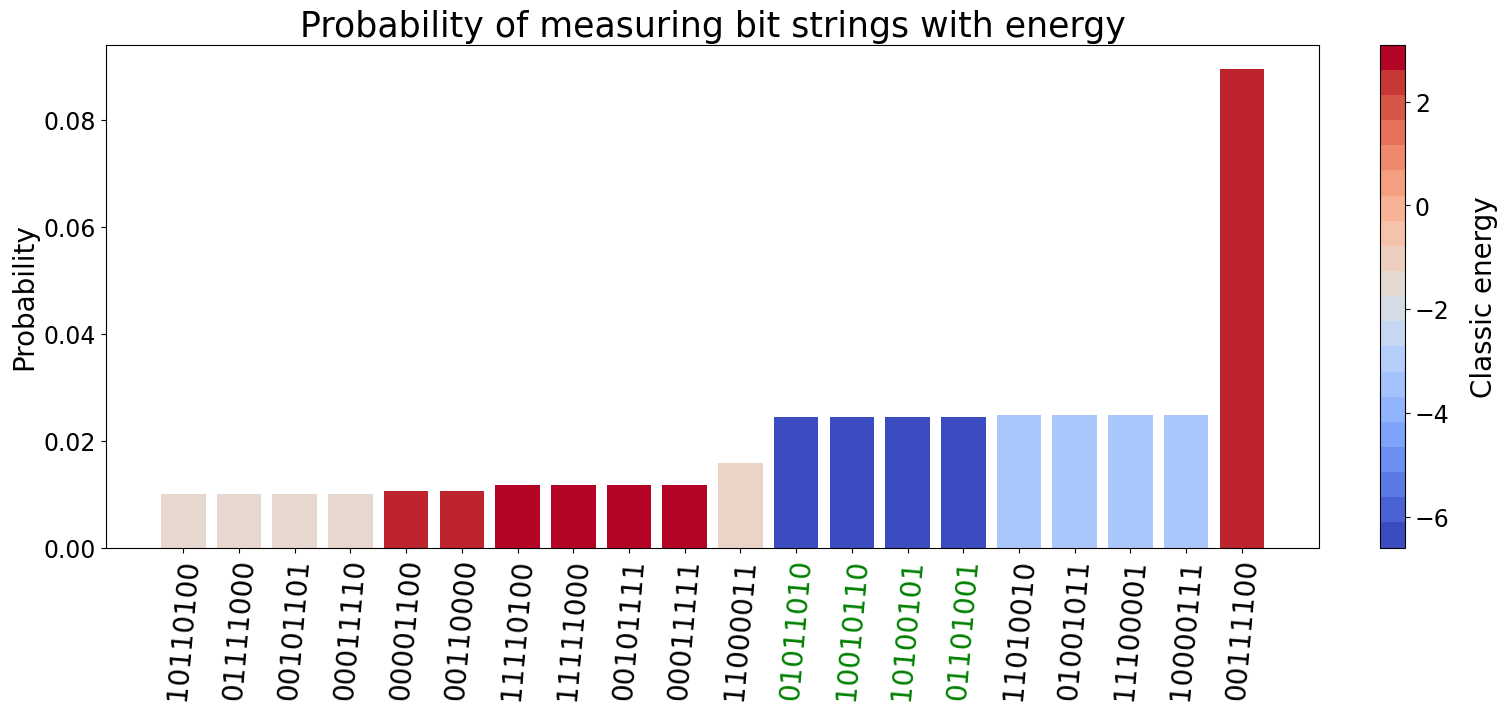

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

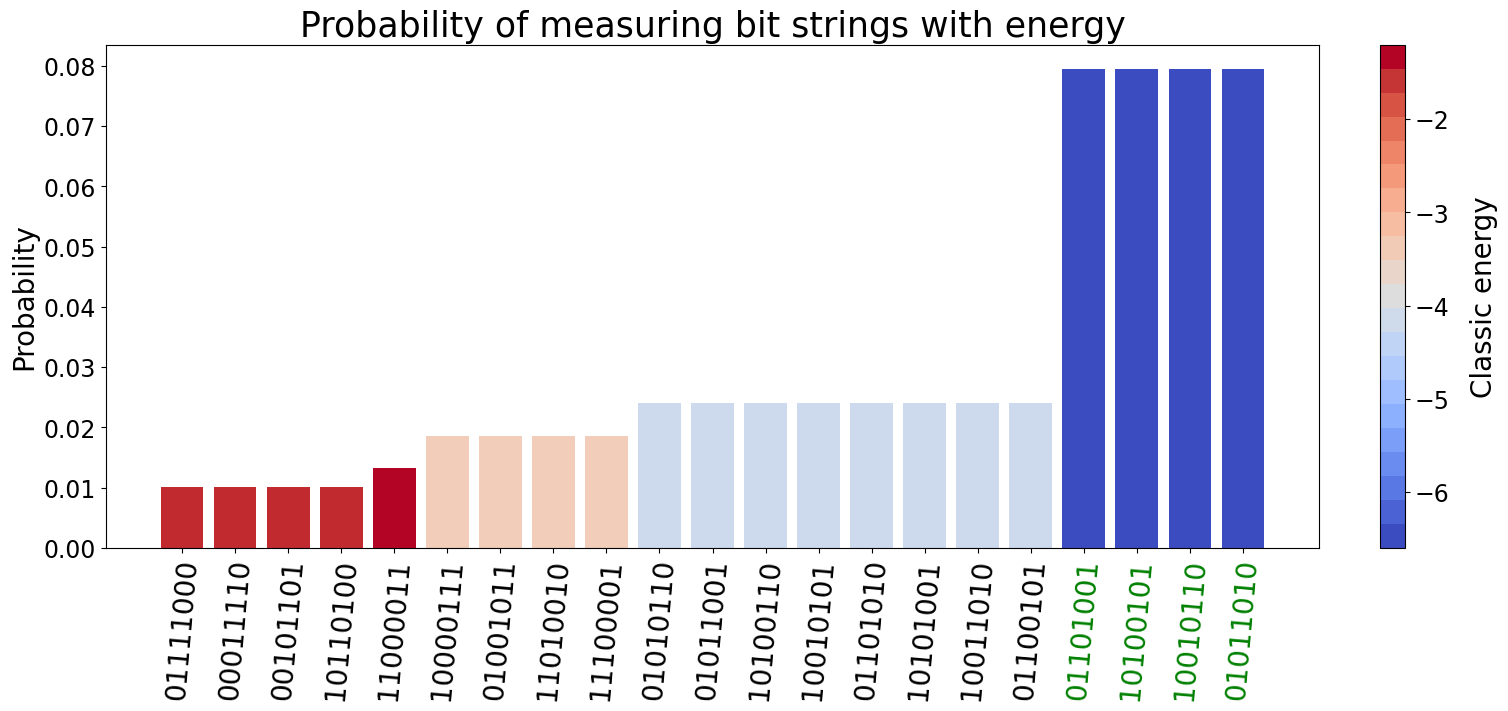

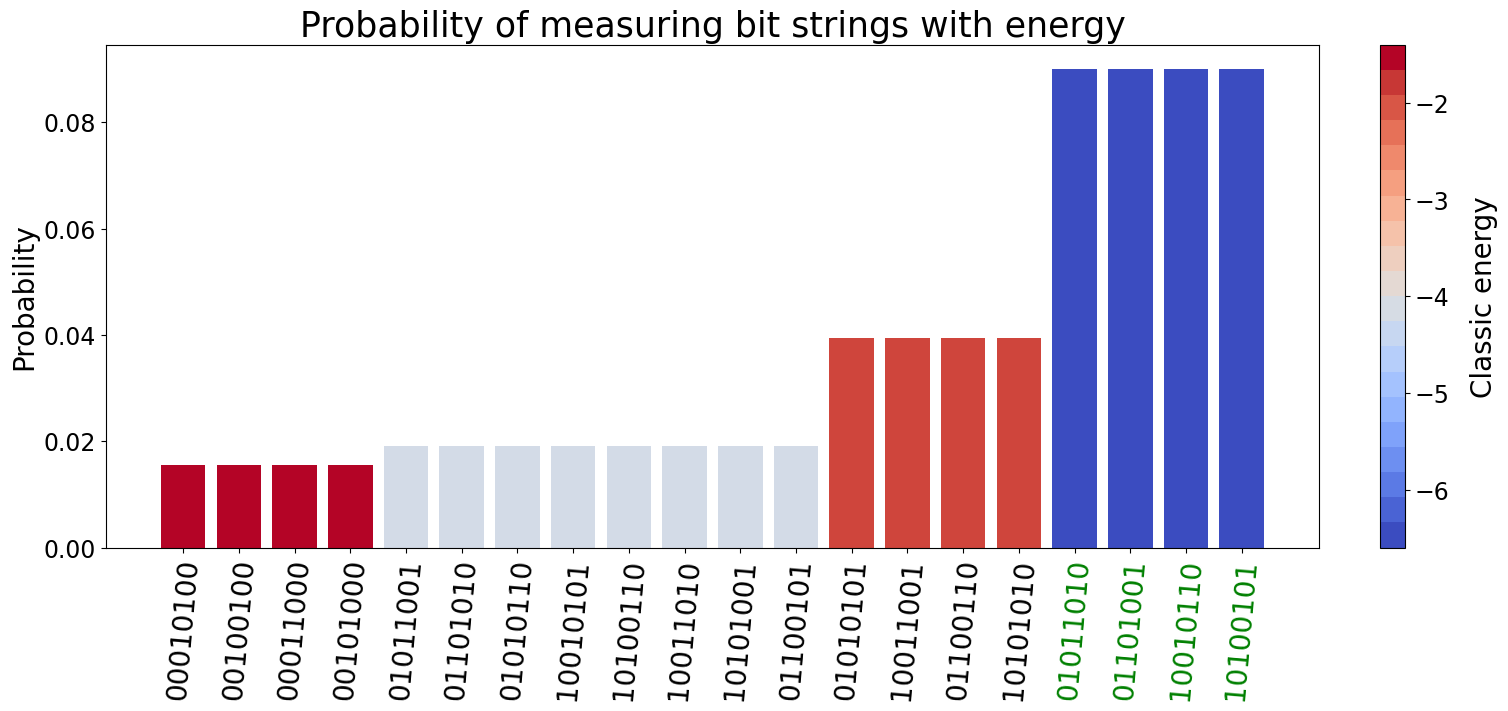

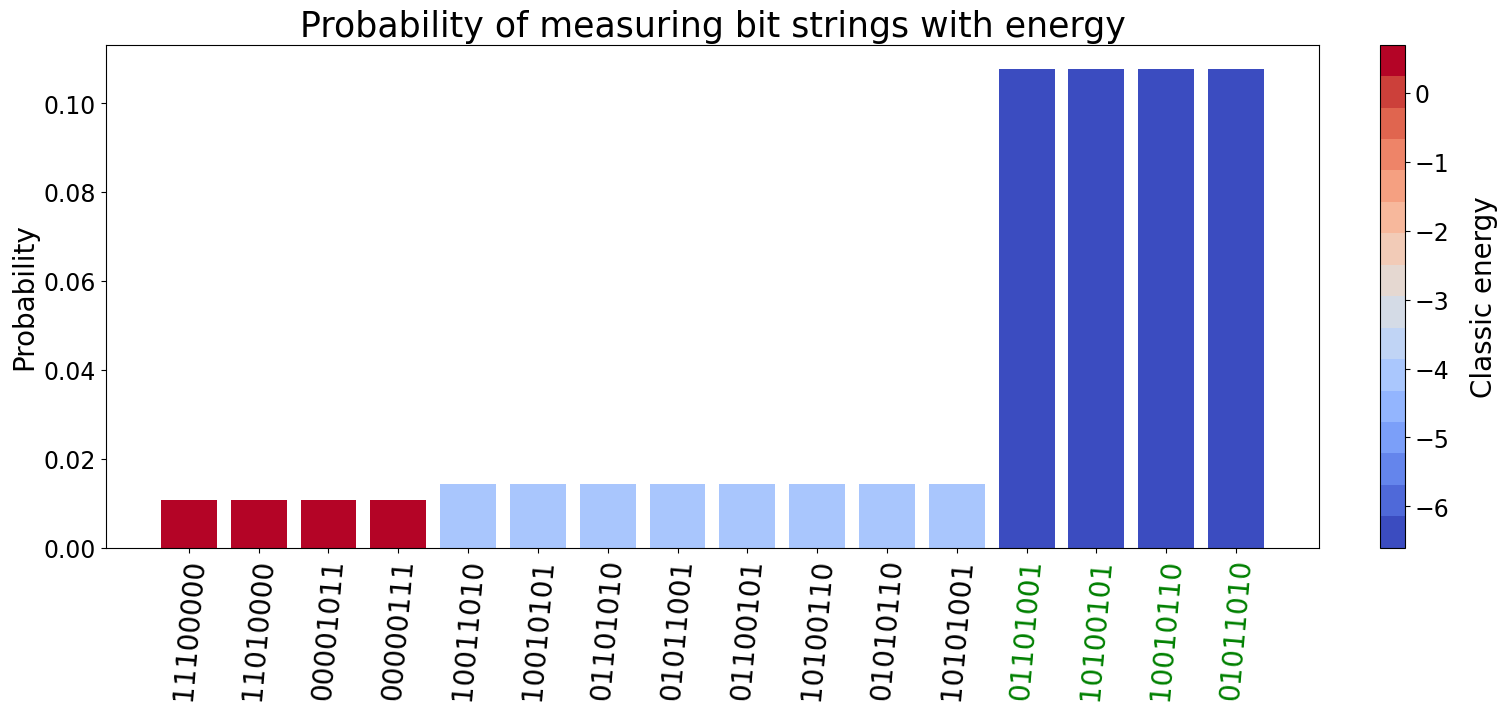

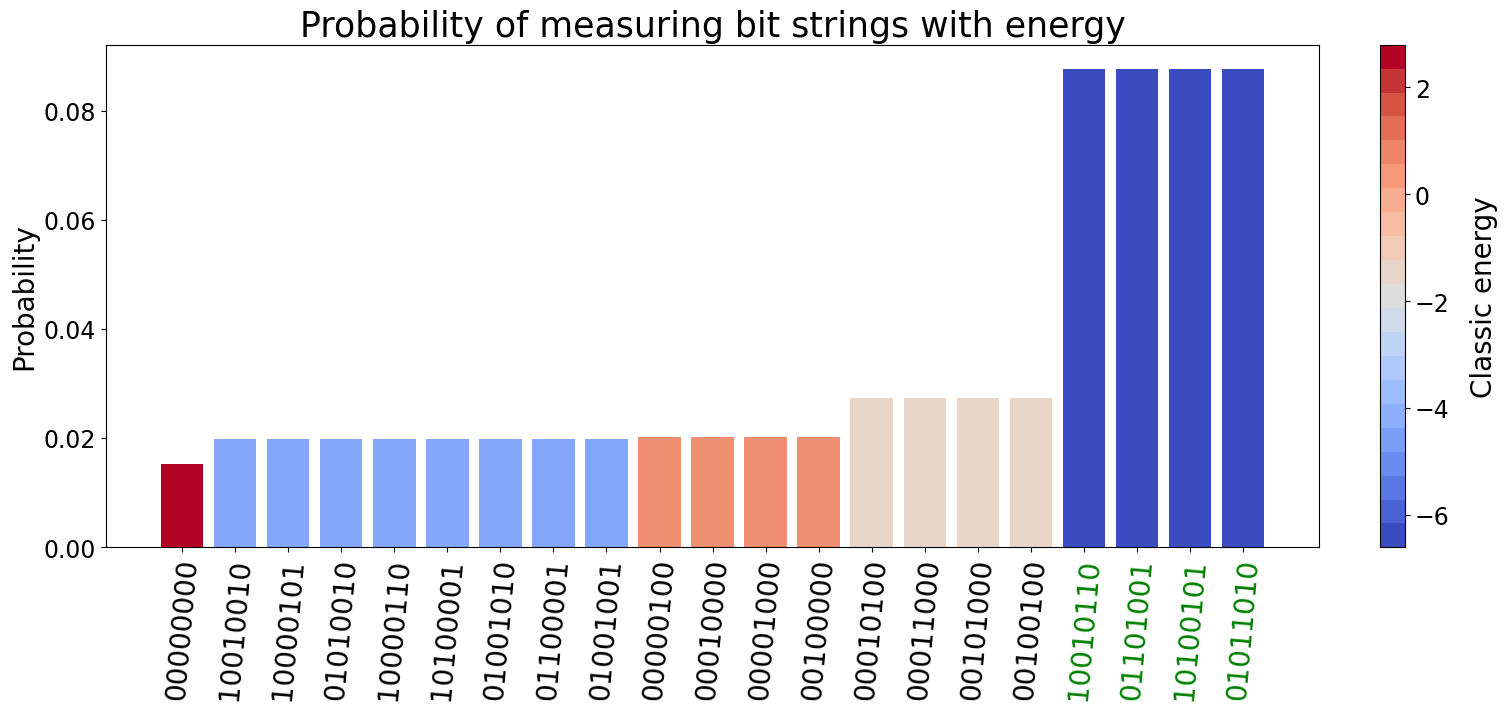

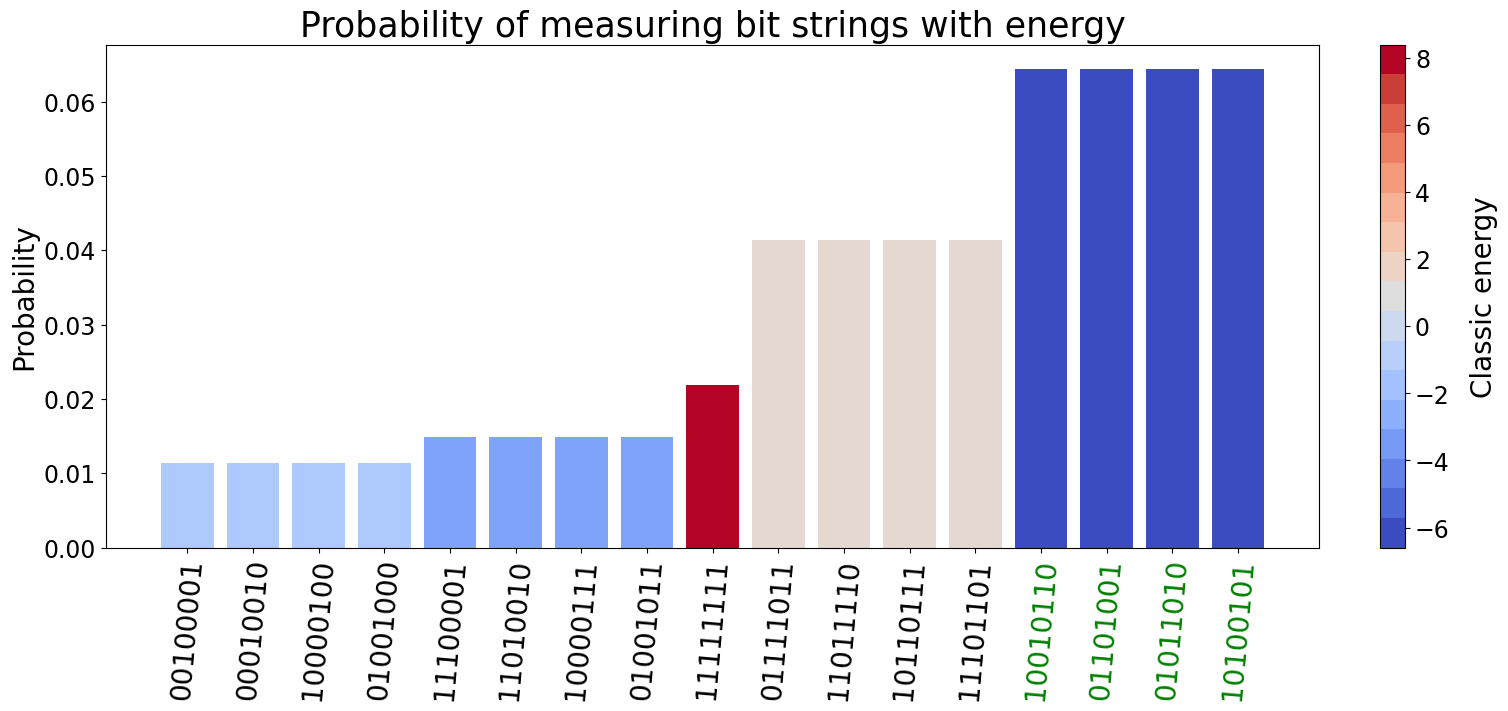

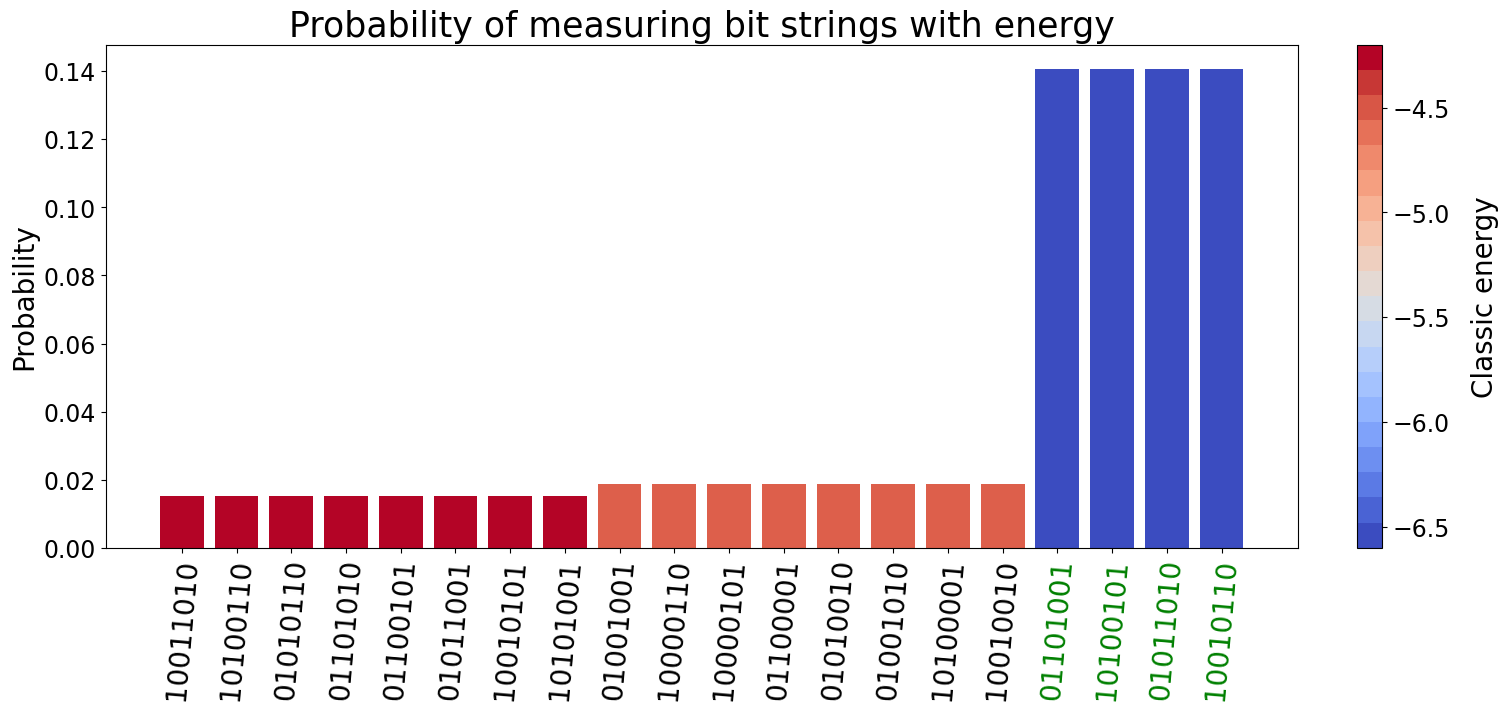

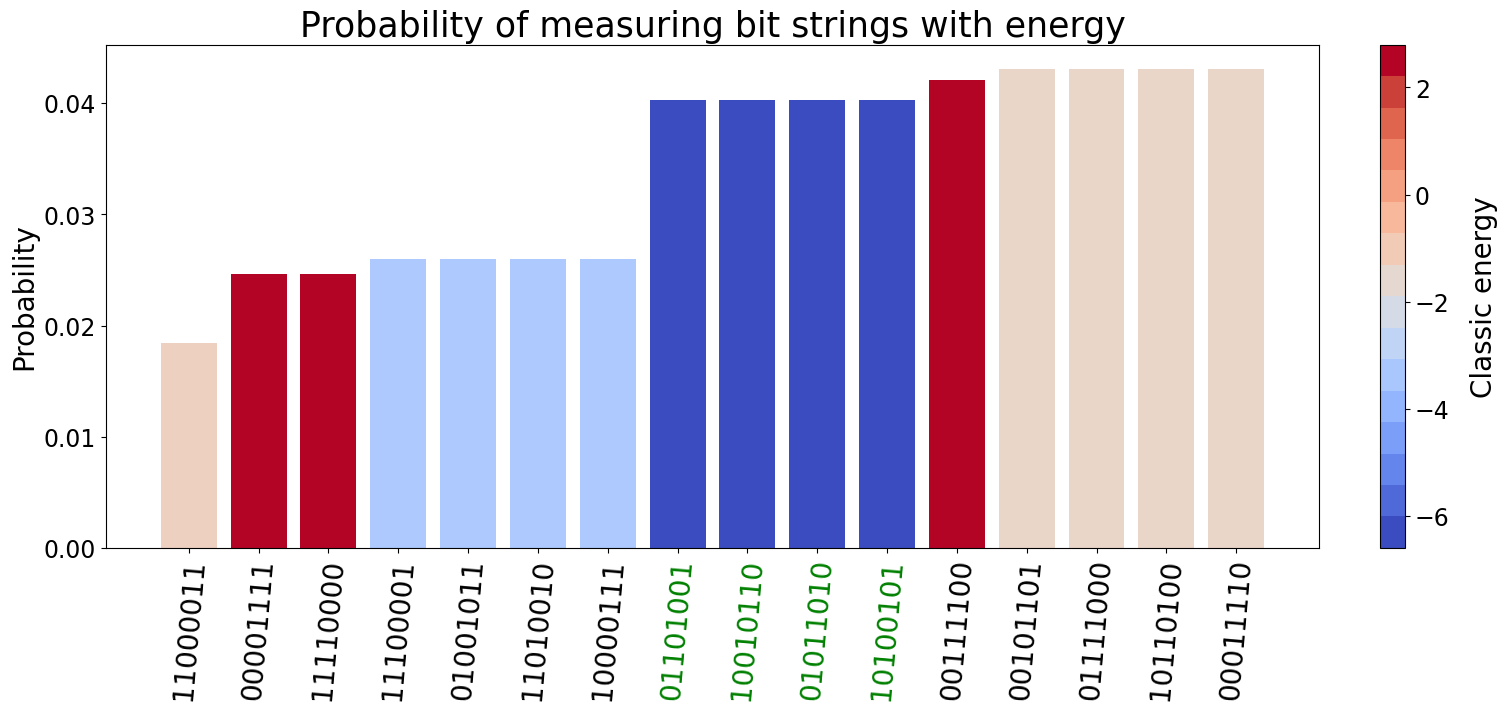

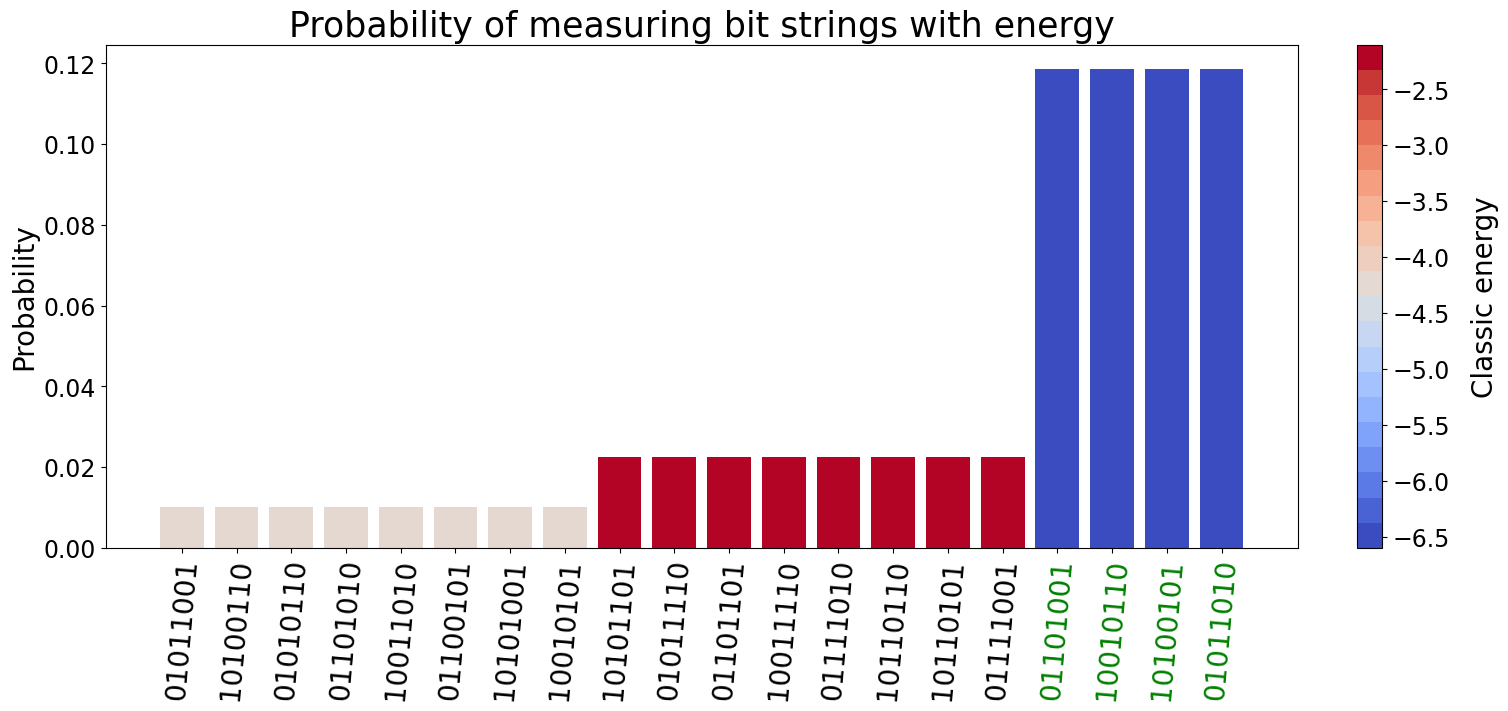

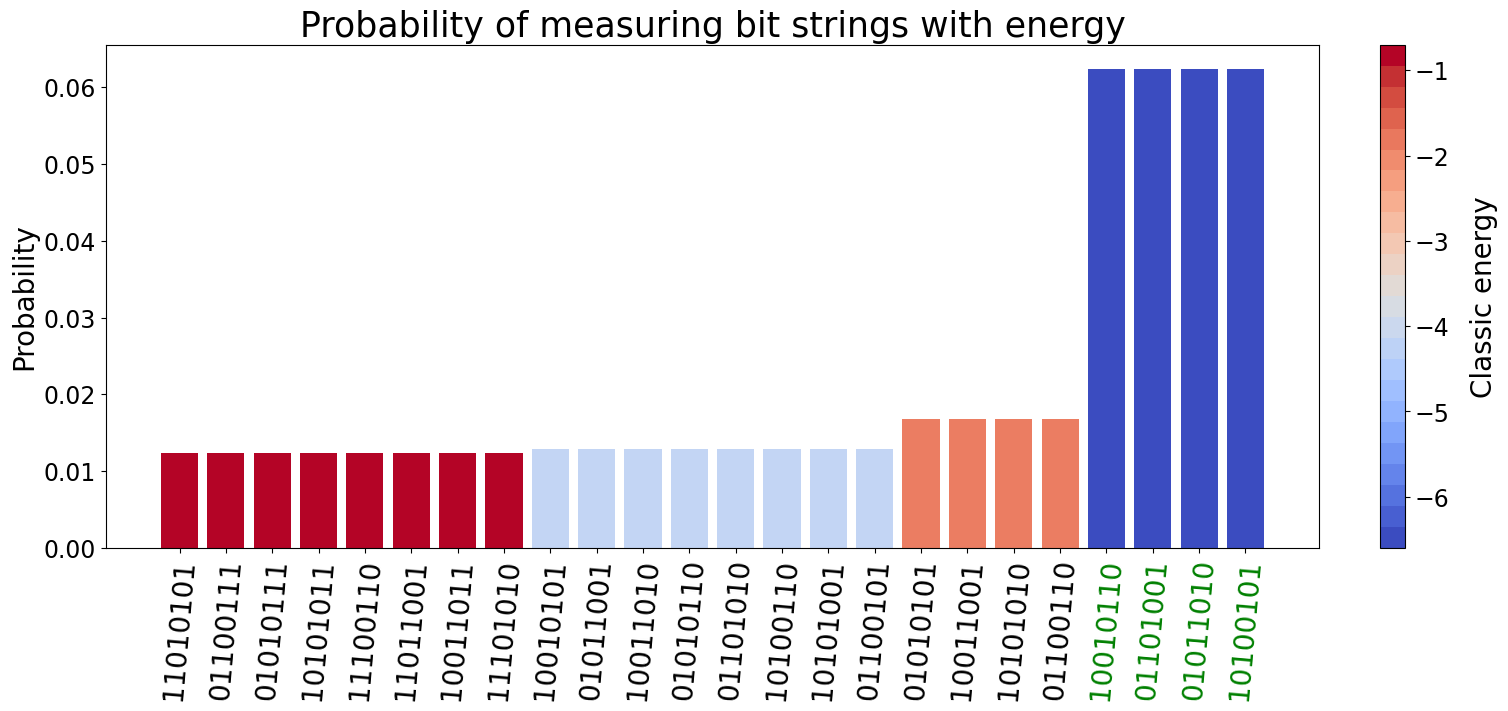

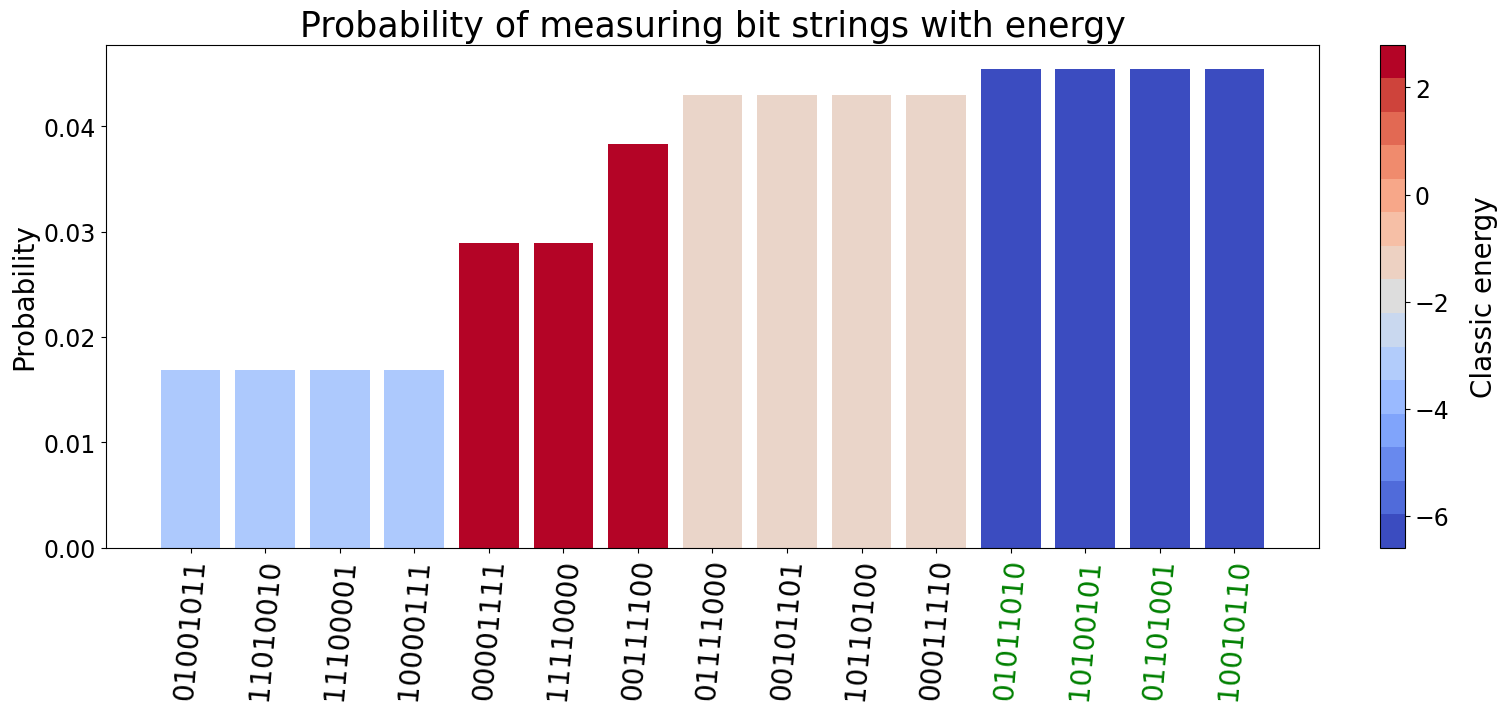

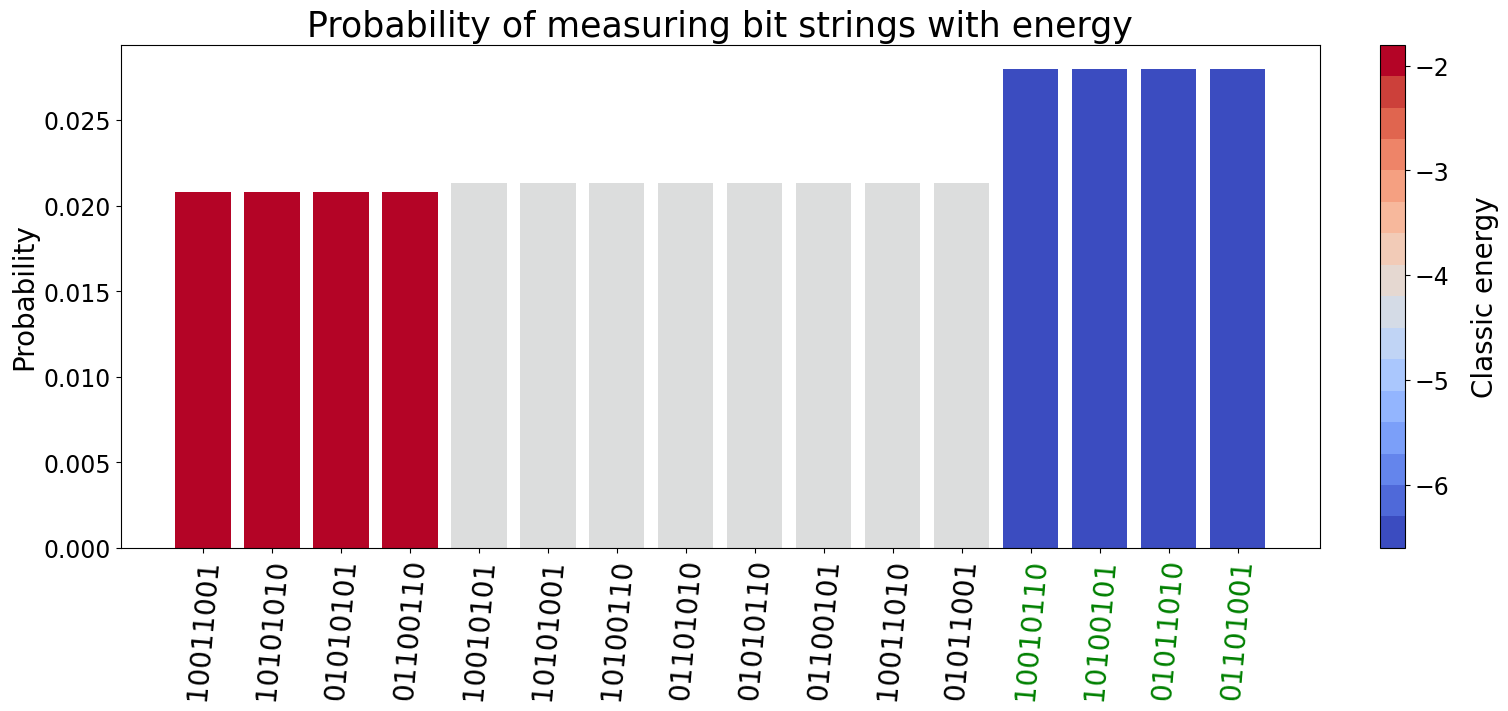

<Figure size 640x480 with 0 Axes>

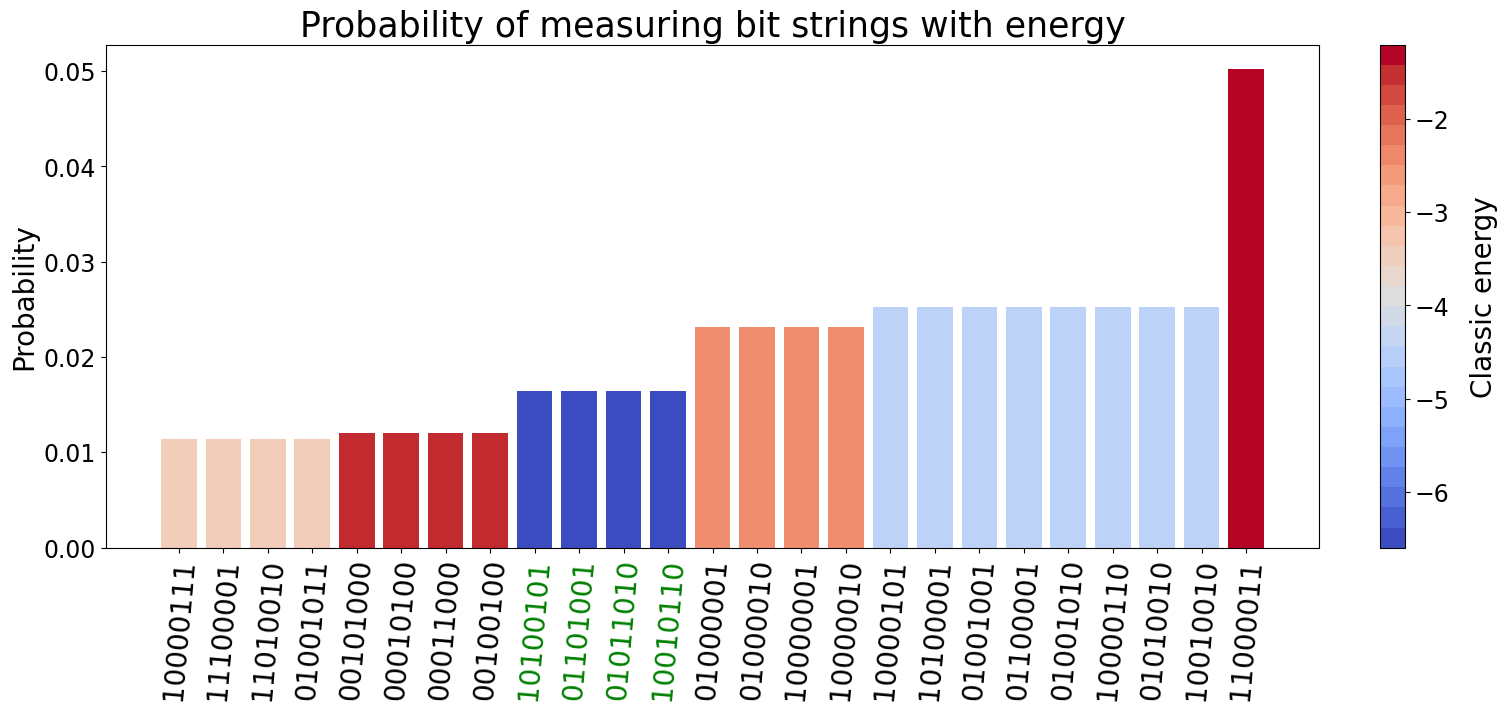

<Figure size 640x480 with 0 Axes>

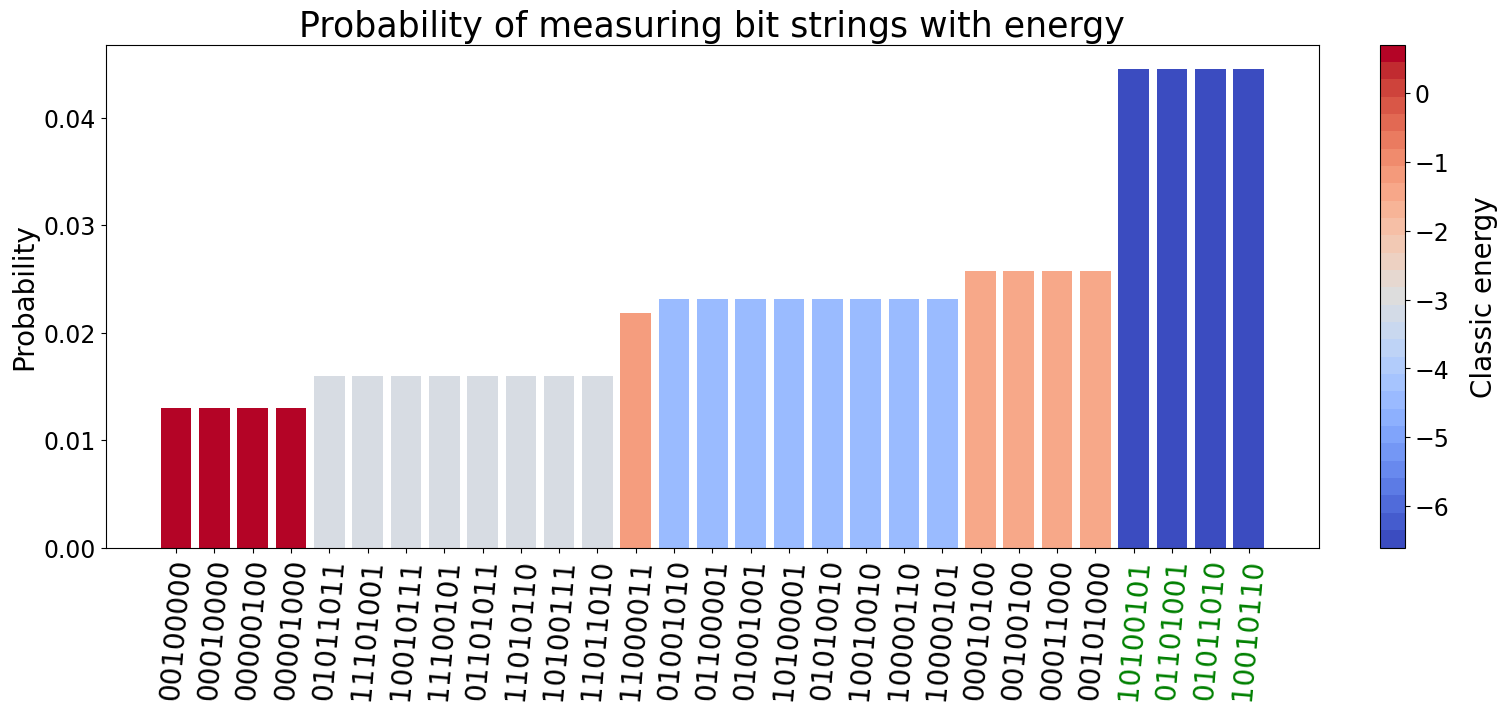

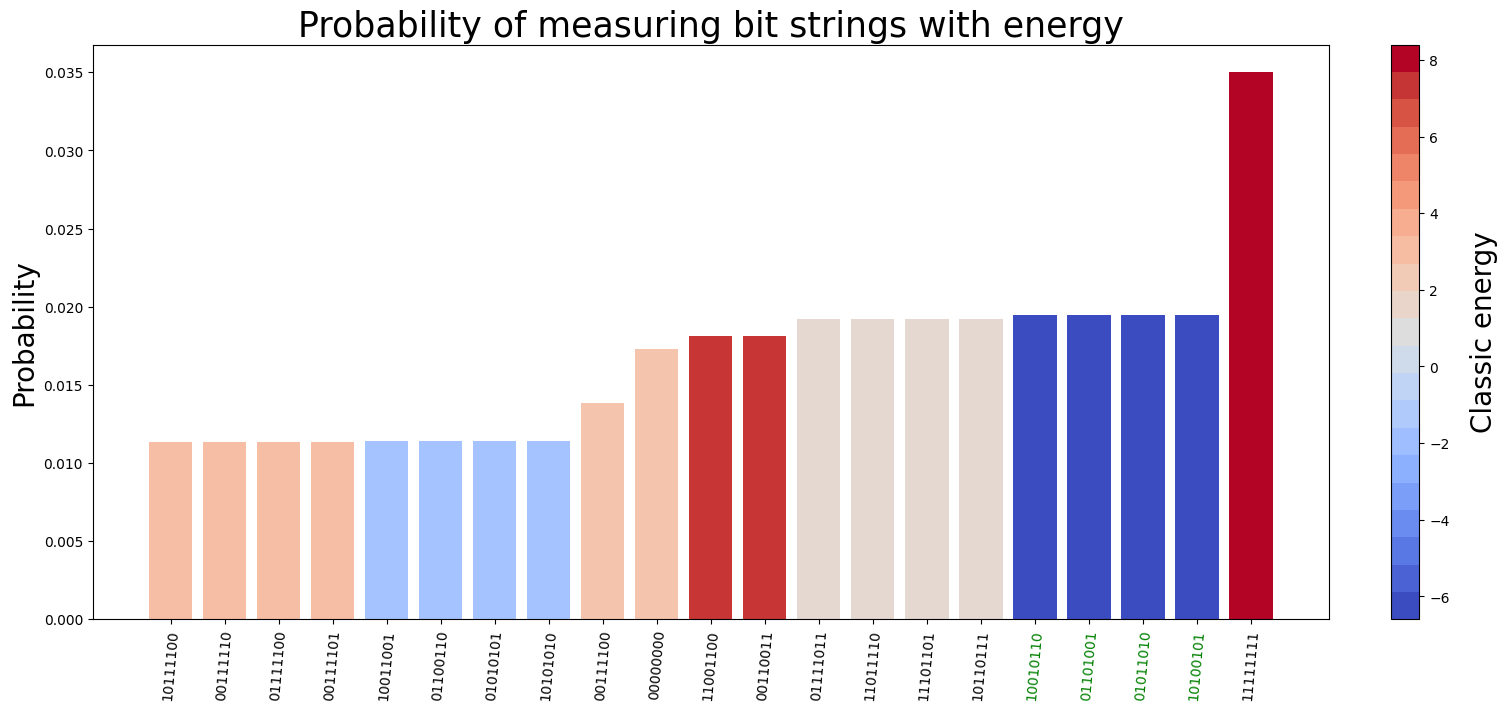

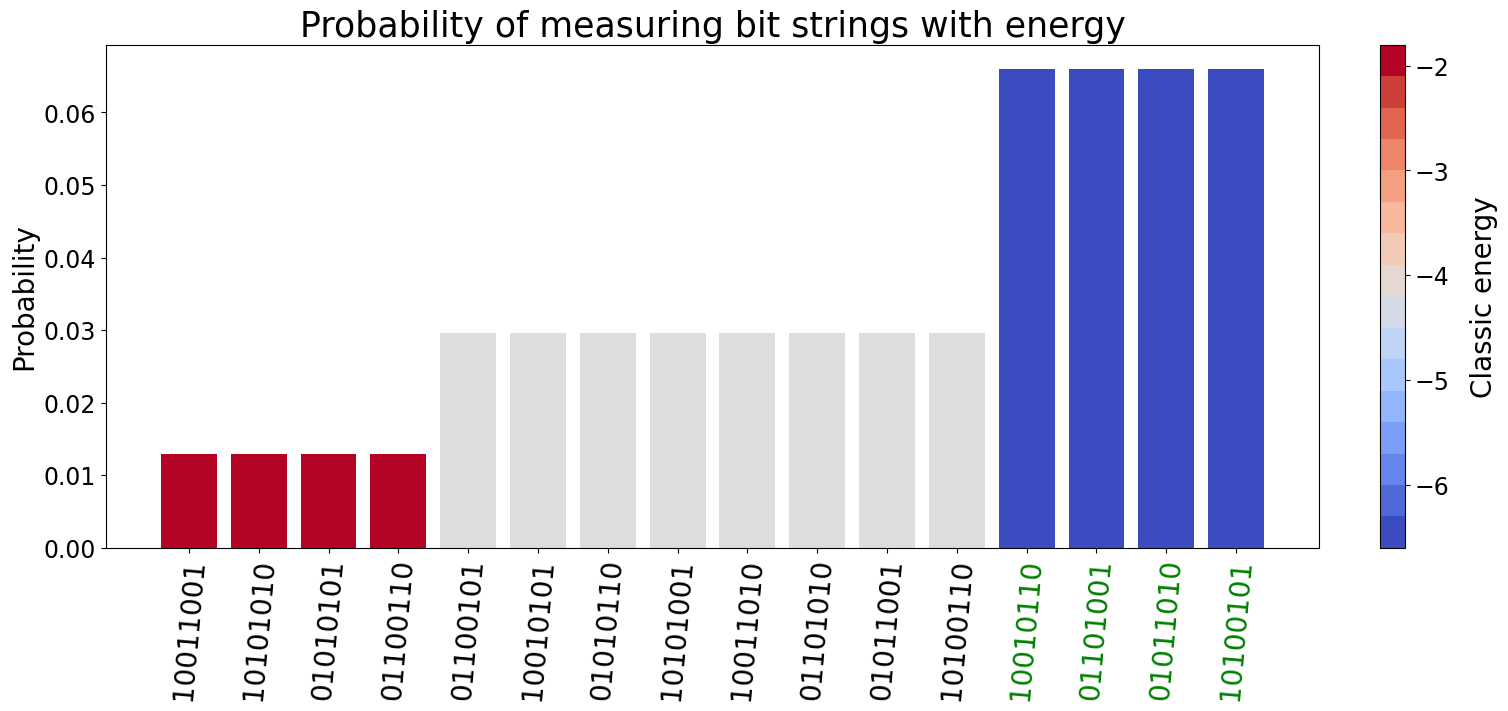

<Figure size 640x480 with 0 Axes>

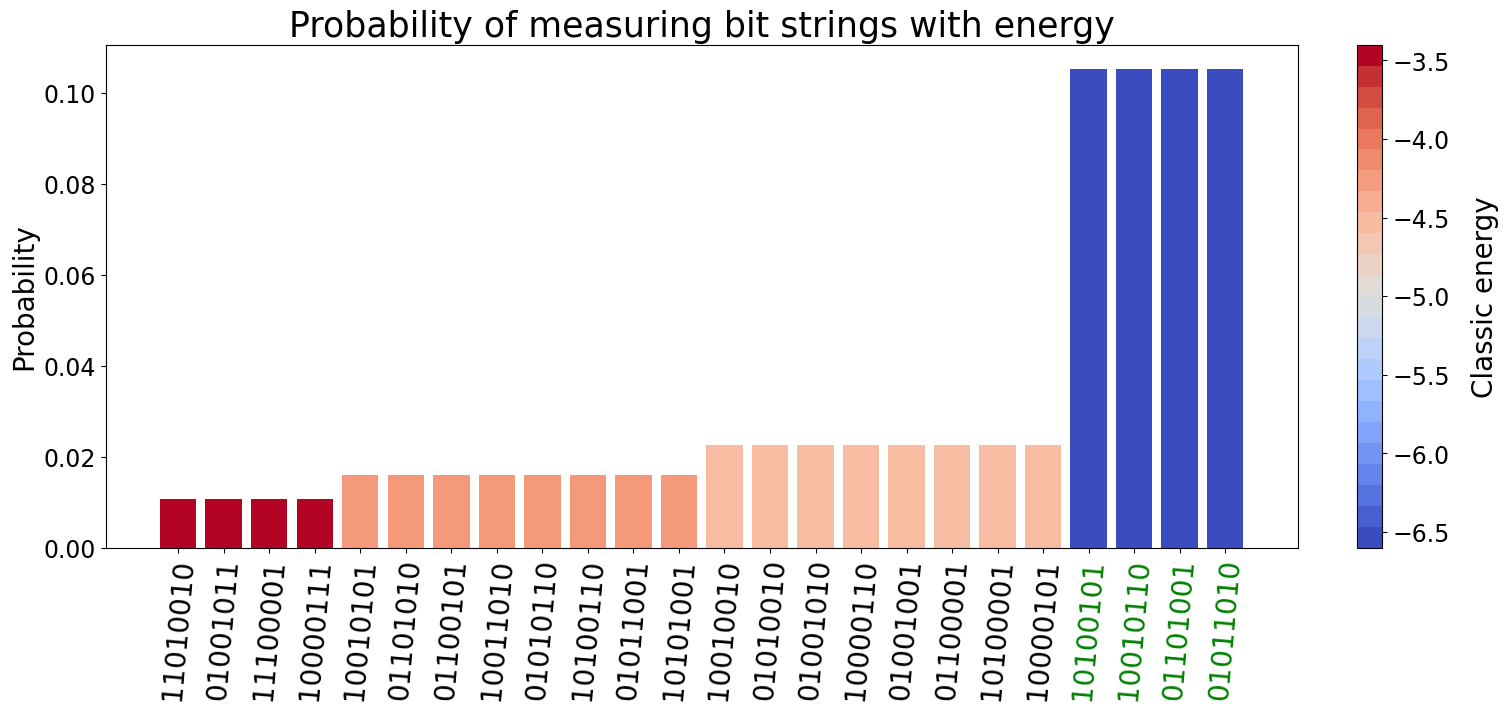

<Figure size 640x480 with 0 Axes>

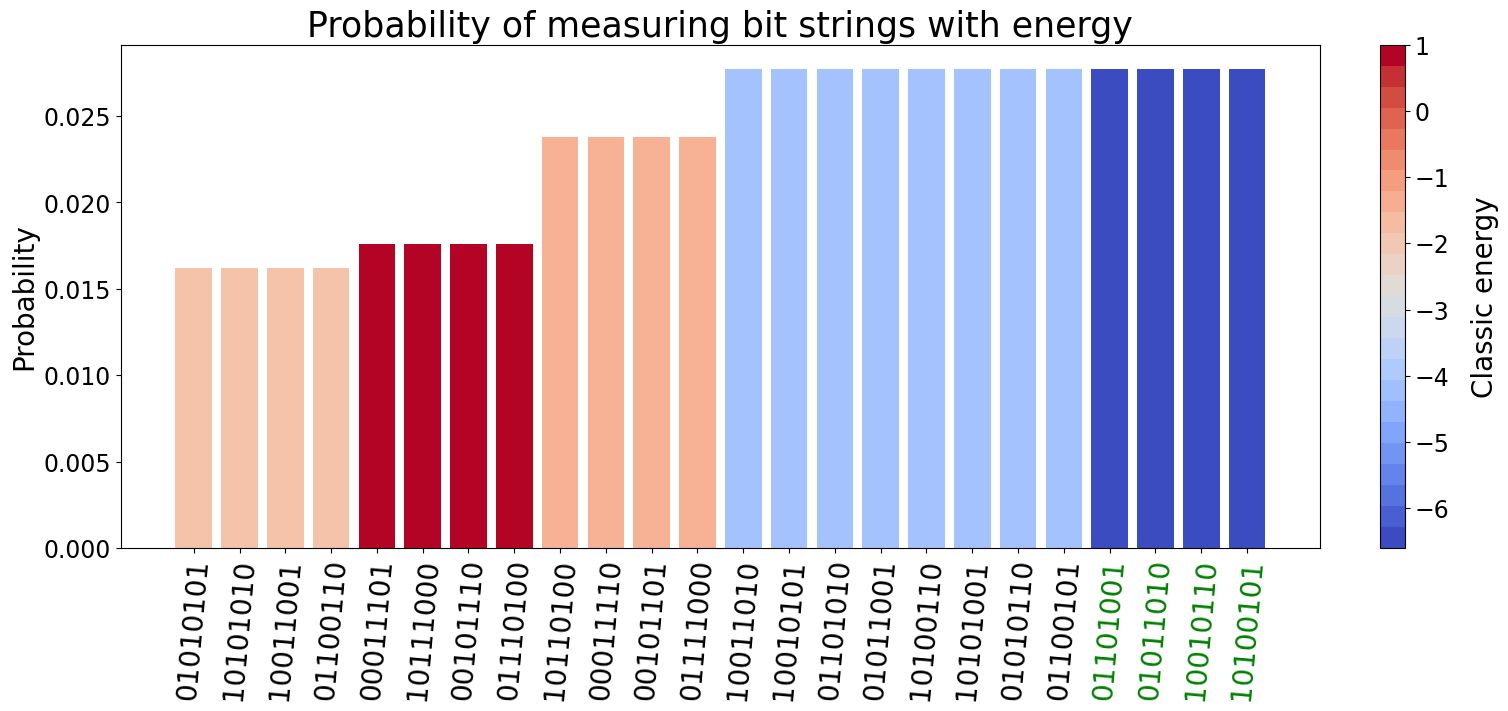

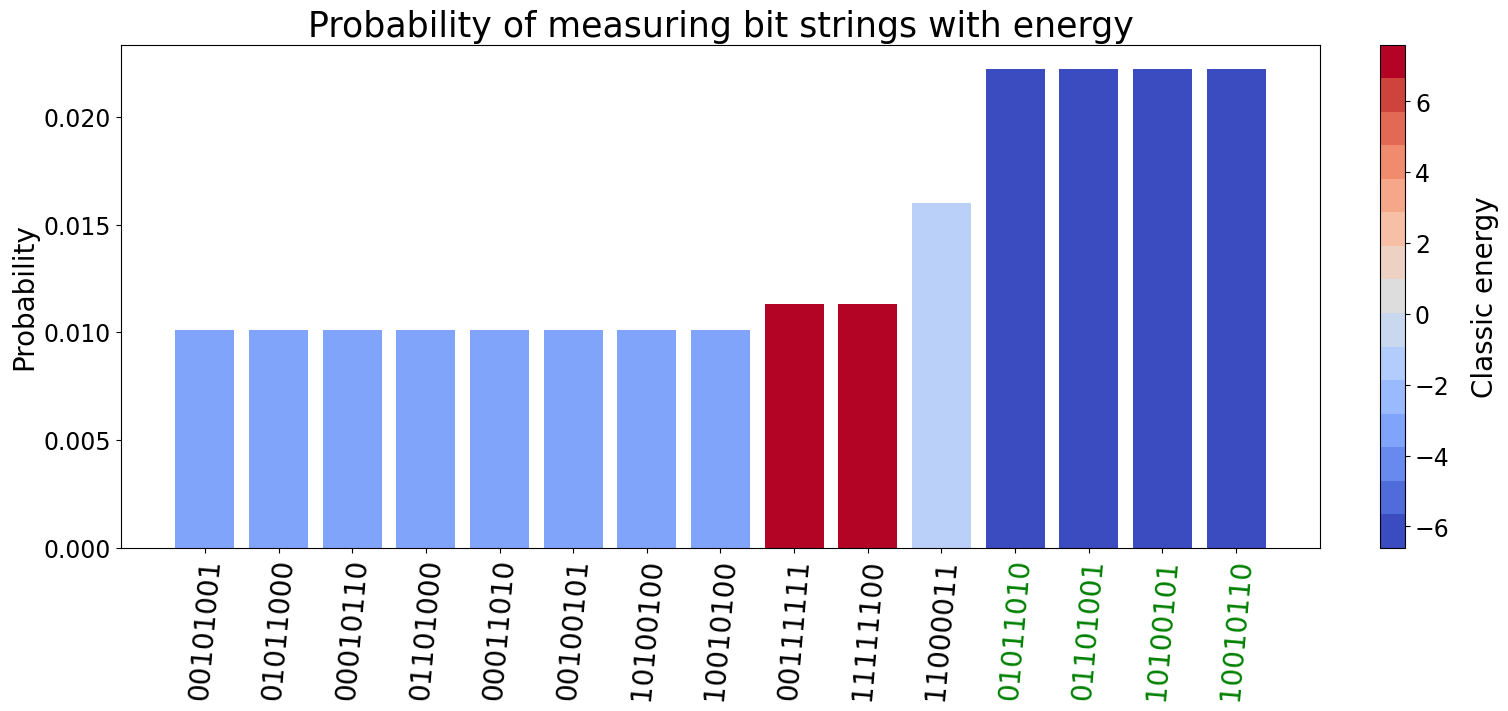

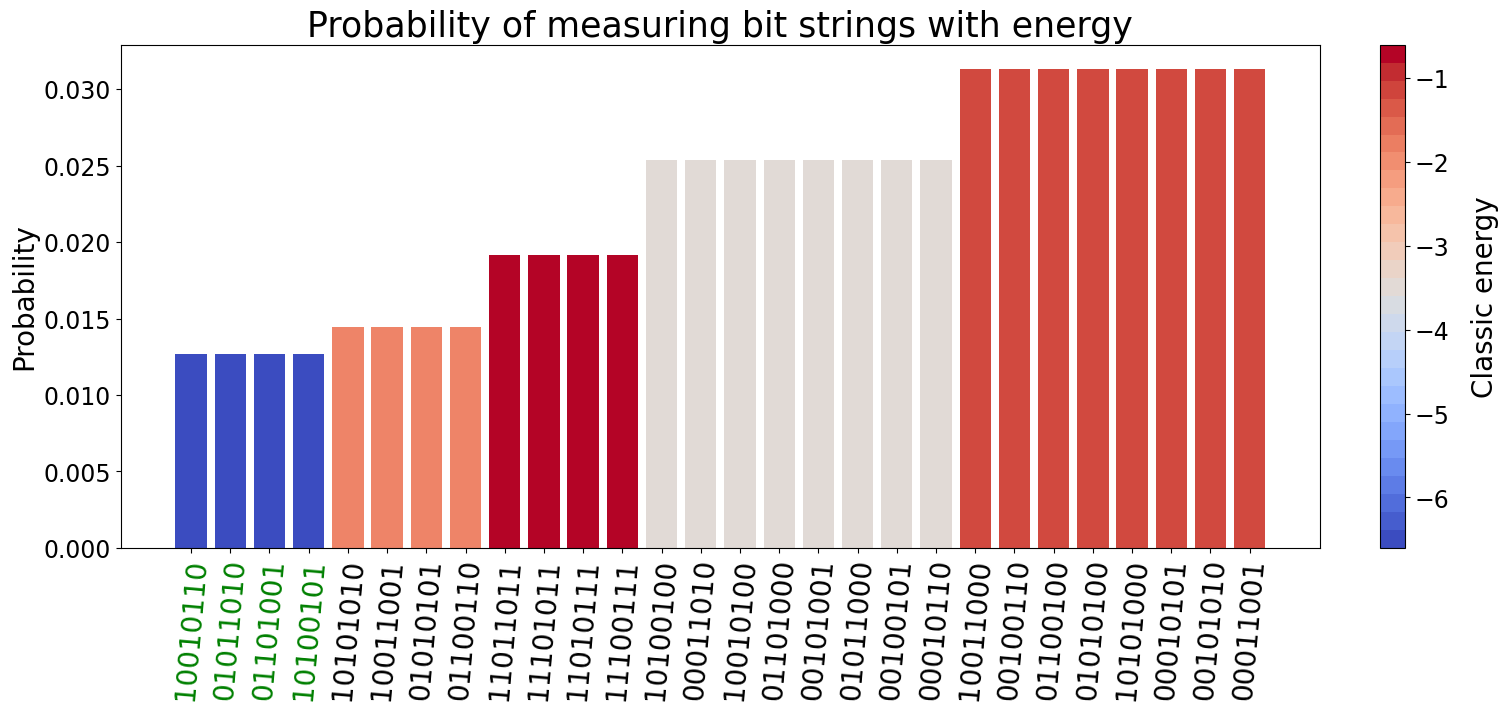

In [6]:
p = 3
m = 1000
a = [.1, .15, .20, .25, .30, .35, .4, .45, .5, .55, .6, .65, .7, .75, .80, .85, .9, .95, 1]
for alpha in a:
    best_params, cost_vector, params_vector = trainGPyOpt()

    @qml.qnode(dev)
    def probability_circuit(params):
        circuit(params)
        return qml.probs(wires=qubits)

    probs = probability_circuit(best_params)

    ground_energy, ground_states_i = get_ground_states_i(feasible_set, H_cost) # get the ground states
    
    print('Alpha (α) = ' + str(alpha))
    print('Success probability of training: ', np.sum(probs[ground_states_i]))
    plot_probs_with_energy(probs, num_qubits, H_cost, ground_states_i) # plot probability over bitstrings

In [ ]:
@qml.qnode(dev)
def probability_circuit(params):
    circuit(params)
    return qml.probs(wires=qubits)

probs = probability_circuit(best_params)

ground_energy, ground_states_i = get_ground_states_i(feasible_set, H_cost) # get the ground states

print('Success probability of training: ', np.sum(probs[ground_states_i]))
plot_probs_with_energy(probs, num_qubits, H_cost, ground_states_i) # plot probability over bitstrings

In [7]:
# Optimisation of the circuit

optimiser = qml.GradientDescentOptimizer()
steps = 100
initial_params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad = True)
p = 2

cost_vector = np.zeros(steps)
cost_vector[0] = CVaRsamp(initial_params) #cvar
params_vector = np.zeros((steps, 2, p))

params = initial_params
for i in range(steps):
    params_vector[i] = params
    params, cost_ = optimiser.step_and_cost(CVaRsamp, params) #cvar
    cost_vector[i] = cost_

best_params_optimisation = params
print('Optimal parameters:\n', best_params_optimisation)
#print('Average cost for the best parameters:\n', average_cost(best_params_optimisation))

ValueError: setting an array element with a sequence.